In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time
import re

import nltk
from nltk.corpus import stopwords

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# <hr><p align='center' style='color: #6c89c6;'>Работу выполнил: Таратин Артём ПМ22-1<br> Датасет: [Russian Social Media Text Classification](https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification)</p>

## <hr>**Глава 1. Основа**

### 1.1 Введение в NLP и классификацию текстов

### 1.2 Методы векторизации текста

### 1.3 Описание используемых библиотек

## <hr>**Глава 2. Работа с датасетом**

### 2.1 Описание Датасета

##### **Оригинал:**
VKontakte communities can belong to one of several predefined categories. But even among the sports communities there is a fairly strong division by subject! The same authors can write about only one sport or at once about a large number. Based on a given set of posts, determine the topic – what kind of sport is being discussed in the selected community?

##### **Перевод:**
Сообщества ВКонтакте могут относиться к одной из нескольких предопределенных категорий. Но даже среди спортивных сообществ существует довольно строгое разделение по тематике! Одни и те же авторы могут писать только об одном виде спорта или сразу о большом количестве. Основываясь на заданном наборе постов, определите тему – какой вид спорта обсуждается в выбранном сообществе?

##### **Список доступных категорий (13):**
* athletics – легкая атлетика,
* autosport – автоспорт,
* basketball – баскетбол,
* boardgames – настольные игры,
* esport – киберспорт,
* extreme – экстрим,
* football – футбол,
* hockey – хоккей,
* martial_arts – боевые искусства,
* motosport – автоспорт,
* tennis – теннис,
* volleyball – волейбол,
* winter_sport – зимний спорт

##### **Функция потерь выглядит так:**
```python
def score(true, pred, n_samples):
    counter = 0
    if true == pred:
        counter += 1
    else:
        counter -= 1
    return counter / n_samples
```

#### 2.2 Анализ, Предобработка данных и вывод основных характеристик

Считываем данные и выводим первые 5 строк

In [3]:
data = pd.read_csv('./train.csv')
data.head()

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [4]:
data.shape, data.category.unique().size

((38740, 3), 13)

In [5]:
data.category.unique()

array(['winter_sport', 'extreme', 'football', 'boardgames', 'hockey',
       'esport', 'athletics', 'motosport', 'basketball', 'tennis',
       'autosport', 'martial_arts', 'volleyball'], dtype=object)

In [6]:
data.dtypes

oid          int64
category    object
text        object
dtype: object

In [7]:
data.isna().sum()

oid         0
category    0
text        0
dtype: int64

Ненужных столбцов нету, также как и выбросов

In [8]:
data.duplicated('text').sum()

2966

Но в то же время присутствуют дубликаты, которые лучше убрать, либо оставить первый

In [9]:
data.drop_duplicates('text', inplace=True, keep='first')
data.duplicated('text').sum()

0

Используем `LabelEncoder()` для предобразования целевого столбца

In [10]:
le = LabelEncoder()
data['category_le'] = le.fit_transform(data.category)
data.head()

,oid,category,text,category_le
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,5
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,6
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,3
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,7


Теперь выведем распределение классов и укажем количество их использований

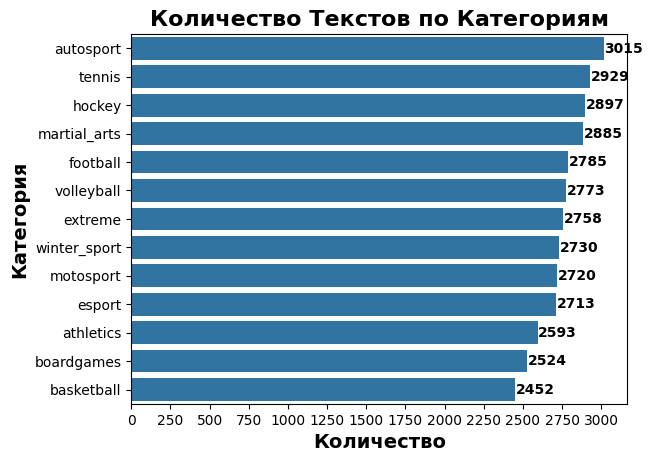

In [11]:
sr = data.groupby('category').text.count()
ix = np.argsort(sr)[::-1]
xp, yp = np.array(sr)[ix], np.array(sr.index)[ix]

ax = sns.barplot(x=xp, y=yp, orient='h')
for i, (value, category) in enumerate(zip(xp, yp)):
    ax.text(value+5, i, f'{value}', va='center', fontweight='bold')  

ax.set_xlabel('Количество', fontsize=14, fontweight='bold')
ax.set_ylabel('Категория', fontsize=14, fontweight='bold')
ax.set_title('Количество Текстов по Категориям', fontsize=16, fontweight='bold')
ax.set_xticks(np.arange(0, 3001, 250))

plt.show()

Как мы видим, распределение категорий довольно близко к равномерному. В таком случае можно использовать метрику `accuracy_score()` т.к. даже при выборе самого популярного класса точность будет достаточно низкой. Также не стоит забывать про метрику `score()`, предложенную создателями датасета. В любом случае, по своему механизму работы она похожа на `accuracy_score()`, так что мы ничего не теряем. Теперь посмотрим на самые популярные и менее популярные слова в текстах.

In [12]:
word_list = re.findall(r'\b\w{2,}\b', ' '.join(data.text.to_numpy()).lower())
df = pd.DataFrame(word_list, columns=['word']).groupby('word').size()
df = df.reset_index(name='count').sort_values('count', ascending=False)
pd.concat([df.head(25).reset_index(drop=True), df.tail(25).reset_index(drop=True)], axis=1)

,word,count,word,count
0,на,39638,манипулировал,1
1,не,23635,мансабын,1
2,что,19917,мансап,1
3,33,19756,манфорд,1
4,по,14054,манси,1
5,за,11337,мануэля,1
6,это,10827,мануэлю,1
7,для,9919,мануэла,1
8,из,9508,мануальный,1
9,но,9212,мануалы,1


Одними из самых популярных оказались предлоги, в то же время в датасете присутствуют слова, употреблённые всего лишь 1 раз. Обе категории слов не влияют на качество классификации, т.к. либо присутствуют в большинстве классов, либо только в одном. Они являются шумом, и их можно удалить.

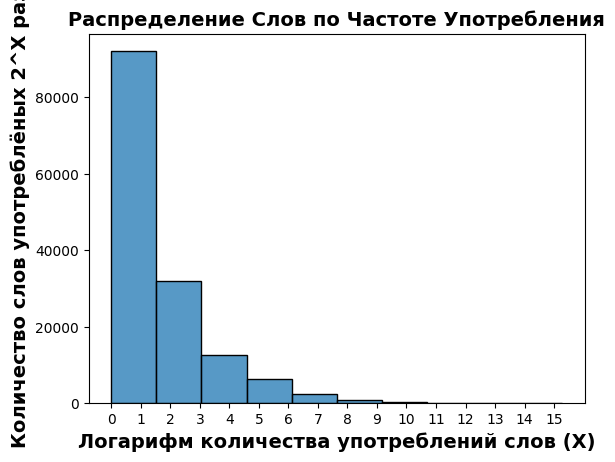

In [13]:
sns.histplot(np.log2(df['count']), bins=10)
plt.xticks(np.arange(0, 16, 1))

plt.title('Распределение Слов по Частоте Употребления', fontsize=14, fontweight='bold')
plt.xlabel('Логарифм количества употреблений слов (X)', fontsize=14, fontweight='bold')
plt.ylabel('Количество слов употреблёных 2^X раз', fontsize=14, fontweight='bold')

plt.show()

Большинство слов используются всего 1-4 раз, что в теории может оказать негативный эффект. Теперь поделим данные на тренировочную, валидационную и тестовую выборки.

In [14]:
X, y = data.text.to_numpy(), data.category_le.to_numpy()
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, stratify=y_test_val)
del X_test_val, y_test_val  # удалим эти переменные, чтобы их после случайно не использовать

В дополнение ко всему, нужно исключить слова русского языка, которые не неут никакой смысловой нагрузки. Для этого используем библиотеку `nltk` и `nltk.corpus.stopwords`

In [15]:
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')
russian_stopwords[:10]

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

Для векторизации текстов и оценки важности слова в контексте документа я буду использовать статистическую меру `tf-idf`. Для оптимизации работы я не буду напрямую векторизировать признаки, вместо этого я использую `Pipeline()` для построения пайплана обучения модели и последующего его обучения.

In [16]:
models = [
    LogisticRegression(n_jobs=-1),
    MultinomialNB(),
    SGDClassifier(n_jobs=-1),
    RandomForestClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_jobs=-1),
    KNeighborsClassifier(n_jobs=-1),
    GradientBoostingClassifier(),
    SVC(),
]

In [ ]:
print(' ' + '_'*49)
all_models_scores = []
for model in models:
        model_name = model.__class__.__name__
        print(f'| Модель {model_name:<40} |')
        start_time = time.time()
        model = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.4, min_df=5, stop_words=russian_stopwords)),
                ('model', model),
        ])
        model.fit(X_train, y_train)
        end_time = time.time()
        learning_time = end_time - start_time

        y_pred = model.predict(X_val)
        score = accuracy_score(y_pred, y_val)
        print(f'|   {score=:.4f} {learning_time=:<18.4f} |', end=f'\n {'_'*49}\n')

        all_models_scores.append({'name': model_name, 'score': score, 'time': learning_time})

In [ ]:
models_df = pd.DataFrame(all_models_scores)
models_df = models_df.sort_values('score', ascending=False).reset_index(drop=True)
models_df

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# MultinomialNB, ComplementNB,
model = Pipeline([
        ('tfidf', TfidfVectorizer(max_df=0.4, stop_words=russian_stopwords)),
        ('model', ComplementNB(alpha=0.25)),
])
model.fit(X_train.tolist(), y_train)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = model.predict(X_train)
accuracy_score(y_pred, y_train), f1_score(y_pred, y_train, average='macro')

In [ ]:
y_pred = model.predict(X_val)
accuracy_score(y_pred, y_val), f1_score(y_pred, y_val, average='macro')

In [ ]:
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test), f1_score(y_pred, y_test, average='macro')

In [ ]:
print(classification_report(y_pred, y_test, zero_division=0))

In [ ]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='.0f')
plt.show()

In [ ]:
# evaluate metric look like
def score(true, pred, n_samples):
    counter = 0
    if true == pred:
        counter += 1
    else:
        counter -= 1
    return counter / n_samples

In [ ]:
y_pred = model.predict(X_test)
sum([score(it, ip, len(y_test)) for it, ip in zip(y_test, y_pred)])